<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/lesson7_wgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install https://download.pytorch.org/whl/cu80/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install fastai
!pip3 install Pillow==4.1.1

    100% |████████████████████████████████| 532.5MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5e992000 @  0x7f113b6842a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.2MB/s 
    100% |████████████████████████████████| 2.0MB 6.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 153kB 4.5MB/s 
    100% |████████████████████████████████| 112kB 5.4MB/s 
  Running setup.py bdist_wheel for nvidia-ml-py3 ... - \ done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.vision.gan import *

## LSun bedroom data

For this lesson, we'll be using the bedrooms from the [LSUN dataset](http://lsun.cs.princeton.edu/2017/). The full dataset is a bit too large so we'll use a sample from [kaggle](https://www.kaggle.com/jhoward/lsun_bedroom).

大規模(large scale)な背景理解(scene understanding)のデータセットの一部を用いる．


In [0]:
path = untar_data(URLs.LSUN_BEDROOMS)

We then grab all the images in the folder with the data block API. We don't create a validation set here for reasons we'll explain later. It consists of random noise of size 100 by default (can be changed below) as inputs and the images of bedrooms as targets. That's why we do `tfm_y=True` in the transforms, then apply the normalization to the ys and not the xs.

保存したデータのパスからGANのアイテムリストを生成する．検証データは作らない（理由は後述）．
xとyの両者に対して，データ増大を行う．


In [0]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .no_split()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

We'll begin with a small side and use gradual resizing.

In [0]:
data = get_data(128, 64)

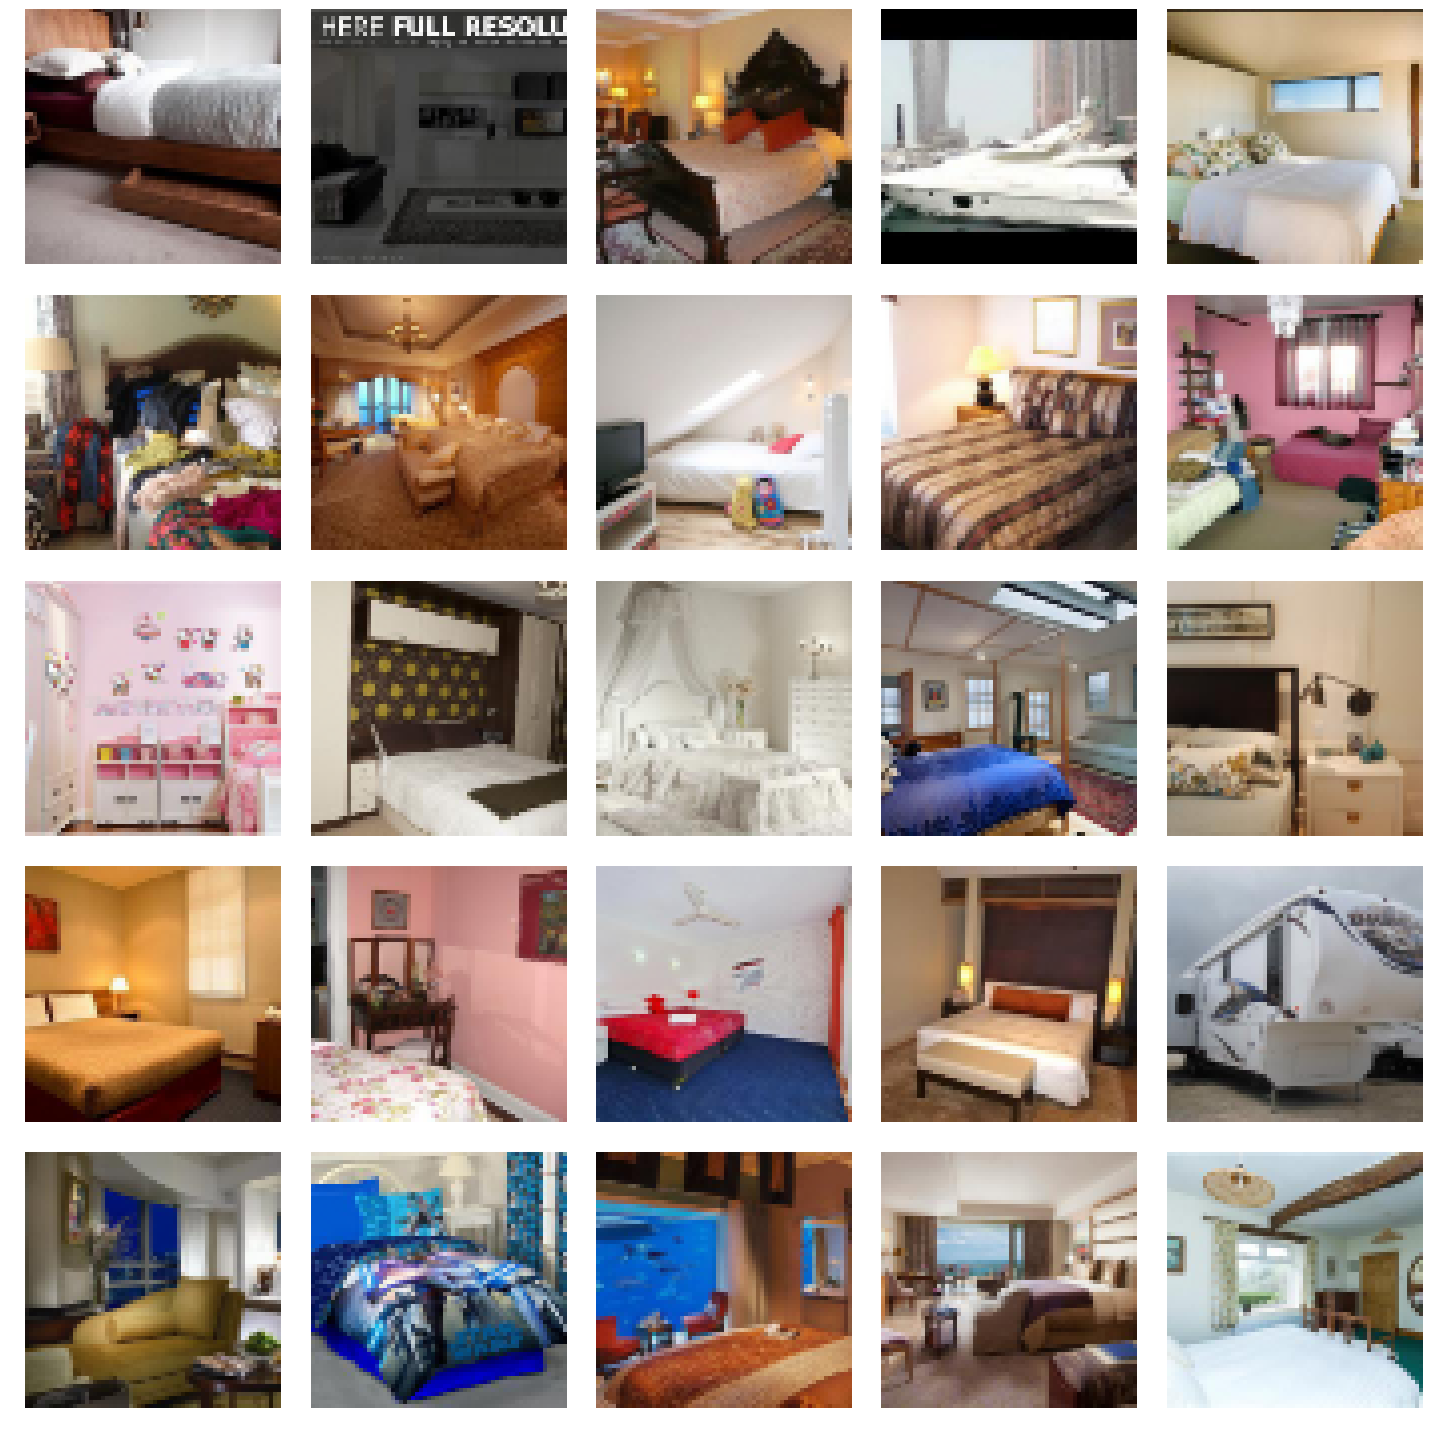

In [7]:
data.show_batch(rows=5)

## Models

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in our dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually 0. for fake images and 1. for real ones).

敵対的生成ネット(GAN)を実装する．

GANは生成器と識別器から構成される．生成器は，与えられたデータにできるだけ近い画像を生成し，識別器はそれが本物か偽物かを識別する．

We train them against each other in the sense that at each step (more or less), we:

1. 生成器を固定して，識別器を訓練する．
Freeze the generator and train the critic for one step by:
  - 正しい画像を1バッチ分生成して，それをrealとよぶ．
  getting one batch of true images (let's call that `real`)
  - 生成器で1バッチ分の偽画像を生成して，それをfaleとよぶ．
  generating one batch of fake images (let's call that `fake`)
  - 識別器で1バッチ分を評価する．その際，正しい画像を識別できたときには正の報酬を与え，偽の画像を正しいと答えたときには負の報酬を与える．
  have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the critic with the gradients of this loss
  
  
2.  識別器を固定して，生成器を訓練する．
Freeze the critic and train the generator for one step by:
  - 1バッチ分の偽画像を生成する．generating one batch of fake images
  - 判別器で評価する．evaluate the critic on it
  - 損出関数は，識別器が本物と答えたら正の報酬を与え，偽物と答えたら負の報酬を与える．
  return a loss that rewards posisitivly the critic thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the generator with the gradients of this loss
  
Here, we'll use the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

We create a generator and a critic that we pass to `gan_learner`. The noise_size is the size of the random vector from which our generator creates images.

In [0]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [0]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [10]:
learn.fit(1,2e-4)　#元は30エポック

epoch,train_loss,gen_loss,disc_loss


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

In [0]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=16, figsize=(8,8))